In [1]:
#!pip install pyLDAvis -qq
#!pip install -qq -U gensim
# Source: https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_lg
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim.matutils import cossim


C:\Users\kforkai\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
listingHk = pd.read_csv('./data/listingHkEn.csv')
listingHk.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,descEn
0,17891,https://www.airbnb.com/rooms/17891,20220614000722,2022-06-14,Large Light Filled Loft,"gorgeous and spacious loft, in the best locati...",Best neighborhood in Hong Kong! A mix of old a...,https://a0.muscache.com/pictures/119686/6ced58...,69063,https://www.airbnb.com/users/show/69063,...,4.90,4.66,NaN,f,1,1,0,0,0.49,"gorgeous and spacious loft, in the best locati..."
1,72571,https://www.airbnb.com/rooms/72571,20220614000722,2022-06-14,SoHo off Hollywood Road 3A,"located steps from hollywood road, with new ea...",NaN,https://a0.muscache.com/pictures/2849554/d2262...,304876,https://www.airbnb.com/users/show/304876,...,4.73,4.13,NaN,f,11,7,4,0,1.10,"located steps from hollywood road, with new ea..."
2,103760,https://www.airbnb.com/rooms/103760,20220614000722,2022-06-14,Central Centre 5 min walk to/from Central MTR,"located right in the heart of central, this 2 ...",NaN,https://a0.muscache.com/pictures/815221/056993...,304876,https://www.airbnb.com/users/show/304876,...,4.71,4.39,NaN,f,11,7,4,0,2.10,"located right in the heart of central, this 2 ..."
3,104626,https://www.airbnb.com/rooms/104626,20220614000722,2022-06-14,Entire Flat - Next to Man Mo Temple,situated in one of hong kong’s most prestigiou...,NaN,https://a0.muscache.com/pictures/1947265/ef01a...,544166,https://www.airbnb.com/users/show/544166,...,4.79,4.71,NaN,t,1,1,0,0,0.11,situated in one of hong kong’s most prestigiou...
4,132773,https://www.airbnb.com/rooms/132773,20220614000722,2022-06-14,Fabulous 2 Bdrm Aprt Open kitchen,"nicely decorated, spacious 2 bedroom apartment...",The Sheung Wan neighbourhood is ever changing ...,https://a0.muscache.com/pictures/36936441/e4c1...,304876,https://www.airbnb.com/users/show/304876,...,4.38,4.36,NaN,f,11,7,4,0,1.58,"nicely decorated, spacious 2 bedroom apartment..."


In [4]:
# Our spaCy model:
nlp = en_core_web_lg.load()
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []
for desc in nlp.pipe(listingHk['descEn']):
   proj_tok = [token.lemma_.lower() for token in desc if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

In [5]:
listingHk['tokens'] = tokens
listingHk['tokens']

0       [gorgeous, spacious, loft, good, location, ava...
1       [locate, step, hollywood, road, new, eatery, a...
2       [locate, heart, central, bed, room, apartment,...
3       [situate, hong, kong, prestigious, residential...
4       [decorate, spacious, bedroom, apartment, heart...
                              ...                        
5668    [apartment, sai, ye, pun, escalator, minute, w...
5669    [f, walk, building, lift, private, bathroom, k...
5670    [equip, room, decorate, calm, neutral, color, ...
5671    [quiet, spacious, place, close, pier, village,...
5672    [sea, ground, level, villa, garden, sai, kung,...
Name: tokens, Length: 5673, dtype: object

In [6]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(listingHk['tokens'])

In [7]:
print(dictionary.token2id)

{'airbnb': 0, 'apartment': 1, 'available': 2, 'balcony': 3, 'bed': 4, 'check': 5, 'commercial': 6, 'concrete': 7, 'cover': 8, 'day': 9, 'design': 10, 'designer': 11, 'dining': 12, 'entertaining': 13, 'equip': 14, 'feature': 15, 'fi': 16, 'fill': 17, 'flat': 18, 'floor': 19, 'fresh': 20, 'ft': 21, 'furnish': 22, 'good': 23, 'gorgeous': 24, 'include': 25, 'inquire': 26, 'kitchen': 27, 'large': 28, 'light': 29, 'linen': 30, 'list': 31, 'location': 32, 'loft': 33, 'long': 34, 'magazine': 35, 'modern': 36, 'monthly': 37, 'numerous': 38, 'open': 39, 'oven': 40, 'perfect': 41, 'plan': 42, 'pm': 43, 'polished': 44, 'printer': 45, 'queen': 46, 'rain': 47, 'rate': 48, 'rental': 49, 'shoot': 50, 'short': 51, 'shower': 52, 'size': 53, 'soho': 54, 'spacious': 55, 'sqf': 56, 'stove': 57, 'table': 58, 'term': 59, 'time': 60, 'towel': 61, 'ultra': 62, 'walk': 63, 'wardrobe': 64, 'wi': 65, 'windows': 66, 'workstation': 67, 'add': 68, 'area': 69, 'art': 70, 'attraction': 71, 'bar': 72, 'bathroom': 73, '

In [8]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [9]:
corpus = [dictionary.doc2bow(doc) for doc in listingHk['tokens']]

In [10]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)


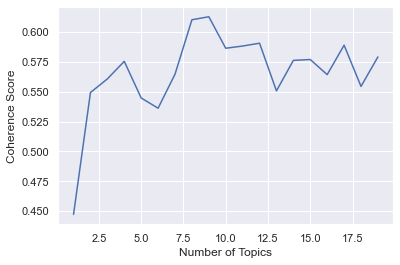

In [11]:
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, texts = listingHk['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [12]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=8, workers = 4, passes=100, random_state=100)

In [13]:
lda_model.print_topics(-1)

[(0,
  '0.027*"minute" + 0.023*"station" + 0.022*"kong" + 0.022*"hong" + 0.020*"shopping" + 0.019*"walk" + 0.017*"mtr" + 0.017*"locate" + 0.015*"bus" + 0.014*"street"'),
 (1,
  '0.036*"share" + 0.028*"need" + 0.022*"electricity" + 0.021*"include" + 0.020*"apartment" + 0.019*"bed" + 0.019*"wifi" + 0.018*"kitchen" + 0.018*"sign" + 0.017*"agreement"'),
 (2,
  '0.036*"apartment" + 0.018*"bed" + 0.018*"tv" + 0.017*"studio" + 0.013*"locate" + 0.012*"service" + 0.011*"air" + 0.010*"include" + 0.010*"equip" + 0.010*"access"'),
 (3,
  '0.019*"apartment" + 0.017*"bedroom" + 0.014*"view" + 0.014*"kitchen" + 0.014*"hong" + 0.014*"kong" + 0.013*"area" + 0.012*"walk" + 0.010*"central" + 0.010*"living"'),
 (4,
  '0.030*"bed" + 0.027*"guest" + 0.017*"private" + 0.016*"stay" + 0.016*"place" + 0.015*"area" + 0.014*"locate" + 0.013*"hong" + 0.013*"kong" + 0.013*"free"'),
 (5,
  '0.053*"min" + 0.046*"walk" + 0.036*"mtr" + 0.031*"station" + 0.018*"bus" + 0.016*"bed" + 0.014*"building" + 0.012*"location" + 

In [14]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

C:\Users\kforkai\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [15]:
x, y = 0, 4947
print(cossim(lda_model[corpus][x], lda_model[corpus][y]))
print('\n',listingHk['descEn'][x], '\n\n',listingHk['descEn'][y])

0.9750076727466694

 gorgeous and spacious loft, in the best location. also available for commercial shoots and longer term rentals. the apartment has been featured on the cover of numerous design magazines, and is listed as one of airbnb's top 40 rentals worldwide. longer term / monthly rates available. also available for commercial shoots, inquire for day rates. large & light-filled, designer open floor plan (800 sqf), fully furnished, with ultra-modern, open kitchen , available for short & long term. includes: - full kitchen (stove top, oven) - fully equipped workstation with wi-fi & printer - balcony & large windows - queen size bed - walk-in wardrobe - 10 ft dining table perfect for entertaining - polished concrete floors - walk-in rain shower - fresh towels & linens check in time: 3pm check out time: 12noon location: the flat is between soho an 

 located in the central area bustling with restaurants and local shops. this is an economic 2-bedroom space for long stays available wi

In [16]:
dictDesc = dict()

for i in range(len(lda_model[corpus])):
    dictDesc[i] = lda_model[corpus][i]
#[lda_model[corpus][i] for i in range(len(lda_model[corpus]))]

In [17]:
ldaList = [lda_model[corpus][i] for i in range(len(lda_model[corpus]))]

In [18]:
df = listingHk.id.to_frame()
df['topics'] = [ldaList[i] for i in df.index]
df.head() 

,id,topics
0,17891,"[(2, 0.54316676), (3, 0.41077125), (7, 0.03760..."
1,72571,"[(0, 0.21305697), (2, 0.2885521), (3, 0.451016..."
2,103760,"[(0, 0.35762772), (3, 0.5243121), (5, 0.109118..."
3,104626,"[(0, 0.35031196), (2, 0.23479569), (3, 0.37003..."
4,132773,"[(0, 0.10304621), (2, 0.37289226), (3, 0.13141..."


In [19]:
cossim(df.topics[0], df.topics[5281])

0.5812858205497322

In [20]:
#df.to_csv('./data/listingTopics.csv', index=False)